# Assignment 8 

Code for reconstructing an image using the Delay-and-Sum (DAS) algorithm that is commonly used in Ultrasound image reconstruction.


In [84]:
import numpy as np
import matplotlib.pyplot as plt

In [85]:
# Main system parameters: number of mics, number of samples in time
Nmics = 64
Nsamp = 200

# Source: x,y coordinates
src = (0, 0)

# Spacing between microphones
pitch = 0.1

# Speed of sound in the medium
C = 2

# proxy for sampling rate
dist_per_samp = 0.1
time_per_samp = dist_per_samp/C

# Time dilation factor for sinc pulse: how narrow
SincP = 5.0

# Locations of microphones
mics = []
zero_flag = 0
for i in range(Nmics):
  if (-Nmics/2+i)*pitch == 0:
    zero_flag = 1
  if not zero_flag:
    mics.append((-Nmics/2+i)*pitch)
  if zero_flag:
    mics.append((-Nmics/2+(i+1))*pitch)
      
# Location of point obstacle
obstacle = (3, -1)

## Distance function

In [86]:
 # Distance from src to a mic after reflecting through pt
def dist(src, pt, mic):
  d1 = ((pt[0] - src[0])**2 + (pt[1] - src[1])**2)**0.5      # distance from src to pt
  d2 = (pt[0]**2 + (mic - pt[1])**2)**0.5                    # distance from pt to mic
  return d1 + d2


## Creating the time axis

In [87]:
samp_timing = []
for i in range(Nsamp):
  samp_timing.append(i*time_per_samp)

## Sinc Function

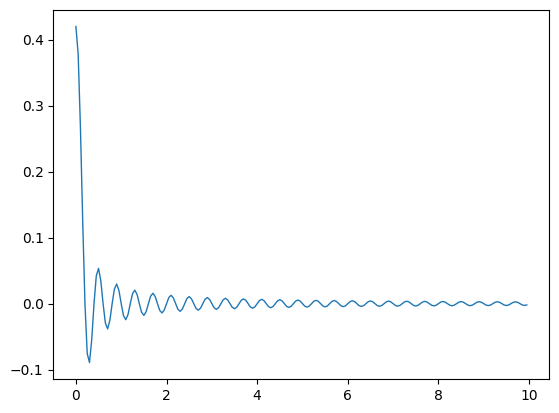

In [88]:
# Source sound wave - time axis and wave
# sinc wave with narrowness determined by parameter
# Nsamp time instants with spacing of dist_per_samp
def wsrc(t):
  y = np.sinc(SincP*t)
  return y*0.42   

sincwave = []
distance = 0
time = distance/C
for j in range(len(samp_timing)):
    sincwave.append(wsrc(samp_timing[j] - time))
    
plt.plot(samp_timing, sincwave, linewidth = 1)
plt.savefig('fig0.png')

The coefficient $0.42$ is chosen such that the peak of the lower wave does not overlap with the upper wave.

## Output wave from each wave

The `y` array stores points to be used for the line plot.\
Whereas, the `y_` araay stores point to be used for the heat map.\
\
The difference between the two is that for the line plot, we must add the location of the mics, which is not required for the heat plot,

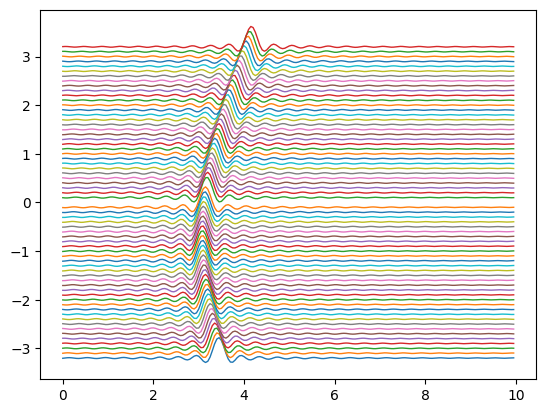

In [89]:
heat_array = []
for i in range(Nmics):
  distance = dist(src, obstacle, mics[i])
  time = distance/C
  
  y = []   # For the line-plot
  y_ = []  # For the heat plot
  
  for j in range(len(samp_timing)):
    y.append(wsrc(samp_timing[j] - time) + mics[i])
    y_.append(wsrc(samp_timing[j] - time))
  
  heat_array.append(y_) 
  plt.plot(samp_timing, y, linewidth = 1)
  plt.savefig('fig1.png')

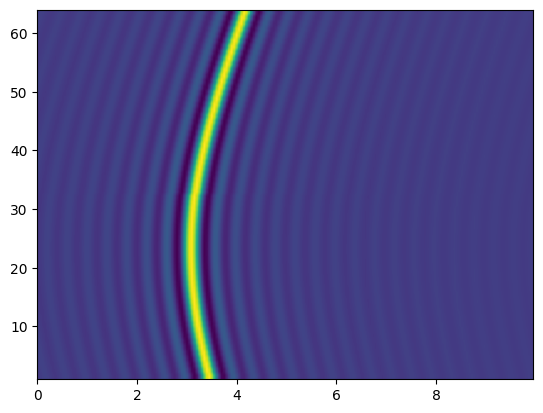

In [90]:
plt.imshow(heat_array, cmap='viridis', aspect='auto', origin='lower', extent=[samp_timing[0], samp_timing[-1], 1, Nmics])
plt.savefig('fig2.png')

## Showing Obstacle (Reconstruction)

Here we apply the Delay and Sum Algorithm. We assume there is an obstacle at any arbitrary point and then store the sum of amplitudes corresponding to time required by sound to travel from source to the mics via that obstacle.\
\
The point which gives the maximum sum denotes the actual location of the obstacle.

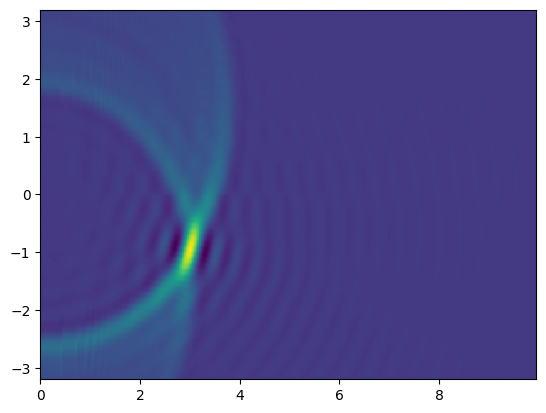

In [91]:
arr = np.zeros((Nmics,Nsamp))
for i in range(Nmics):
  for j in range(Nsamp):
    point = (samp_timing[j],mics[i])
    for k in range(Nmics):
      delay = dist(src, point, mics[k])/C
      closest_time = min(samp_timing, key=lambda x: abs(x - delay))
      index = samp_timing.index(closest_time)
      arr[i][j] += heat_array[k][index]
      
plt.imshow(arr, cmap='viridis', aspect='auto', origin='lower', extent=[samp_timing[0], samp_timing[-1], mics[0], mics[-1]])    
plt.savefig('fig3.png')

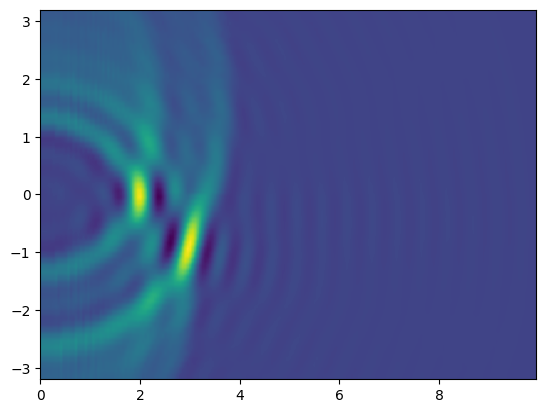

In [92]:
file_path = 'rx2.txt' 
heat_array = np.loadtxt(file_path)


arr = np.zeros((Nmics, Nsamp))
for i in range(Nmics):
  for j in range(Nsamp):
    point = (samp_timing[j], mics[i])
    for k in range(Nmics):
      tof = dist(src, point, mics[k]) / C
      closest_time = min(samp_timing, key=lambda x: abs(x - tof))
      index = samp_timing.index(closest_time)
      arr[i][j] += heat_array[k][index]

plt.imshow(arr, cmap='viridis', aspect='auto', origin='lower', extent=[samp_timing[0], samp_timing[-1], mics[0], mics[-1]])    
plt.savefig('fig4.png')

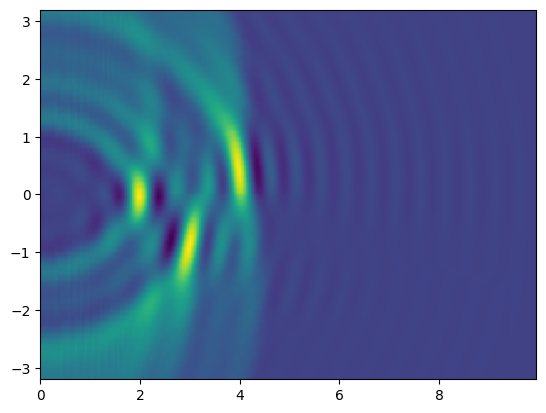

In [93]:
file_path = 'rx3.txt'
heat_array = np.loadtxt(file_path)

arr = np.zeros((Nmics, Nsamp))
for i in range(Nmics):
  for j in range(Nsamp):
    point = (samp_timing[j], mics[i])
    for k in range(Nmics):
      tof = dist(src, point, mics[k]) / C
      closest_time = min(samp_timing, key=lambda x: abs(x - tof))
      index = samp_timing.index(closest_time)
      arr[i][j] += heat_array[k][index]

plt.imshow(arr, cmap='viridis', aspect='auto', origin='lower',extent=[samp_timing[0], samp_timing[-1], mics[0], mics[-1]])    
plt.savefig('fig5.png')

# Questions

QUESTION: 

The plots below show two example sinc pulses. How will you generate pulses that look like this? Which parameter should be changed? What effect do you think this will have on the final image?

ANSWER:
- Function: $np.sinc(SincP*t)$
- On changing SincP from 5 to 1, the graph given in question appears.
- That is the function = np.sinc(t).
- As SincP increases the signal decays faster. 

QUESTION:

Does it make sense to reconstruct up to Nsamp? What value is more reasonable as an upper limit for the x-axis here?

ANSWER:

- The upper limit to x -axis must be $Nsamp*distpersamp/2$ or $Nsamp*distpersamp/C$ whichever is lower.
- In this case C=2, so any of the above two work as they are same.
- This is because mic samples till $distpersamp*Nsamp$ and the wave has to travel $distpersamp*Nsamp/2$ forward and then $distpersamp*Nsamp/2$ backward to make x-coordinate=0.(mics are present on x=0)

QUESTION:

The (x, y) coordinates corresponding to the maximum amplitude (yellow colour) is approximately(30, 22). Explain why this is the correct expected position for the given obstacle

ANSWER:

- 30 represents $30*0.1 = 3$ in x-axis.
- 22 represents 23rd mic that is y-coordinate = -0.95.

QUESTION:

What is the maximum obstacle x- and y- coordinate that you can use and still have an image reconstructed?

ANSWER:

- Max x and max y can be such that maximum distance dalay equals to source to obstacle + obstacle to furthest mic is not greater then $Nsamp*distpersamp$.

QUESTION:

What happens if C is different - if C is decreased it looks like the image becomes sharper. Can you explain why intuitively?

ANSWER:

- When C decreases, we get a larger interval of time for which source is active which results in larger amount of data collection by each mic resulting in a sharper image.

QUESTION:

What happens if Nmics is increased or decreased? Do the experiments with Nmics = [8,32,64] and Nsamp = [50,100,200] (all combinations). Attach the resulting images.

ANSWER:

- If Nmics increases, obstacle is more clearly visible as a point.